In [1]:
# Assuming an infinitesimally small raft, and a spool whose diameter is determined entirely by
#  how much string is wound onto it, calculate the cable length error incurred by assuming a 
# constant diameter.
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib

In order to compute the total length error incurred by not considering a non-ideal spool of starting radius $r_0$ (one for which for which the radius changes according to the change in angle due to thread spooled onto it), start with the arc length formula:

$$
s = r_0 \theta 
$$

Then, taking the convention that a positive angular change produces a positive change in length of thread played out $ds$, for a small change in angle $d\theta$,

$$
\frac{ds}{d\theta} = \frac{d}{d\theta}(r_0 \theta)
$$

$$
\frac{ds}{d\theta} = \frac{dr}{d\theta}\theta + r_0 \frac{d\theta}{d\theta} = \frac{dr}{d\theta}\theta + r_0,
$$

recognizing that for an ideal spool, $\frac{dr}{d\theta} = 0$, so this reduces to

$$
\frac{ds}{d\theta} = r_0,
$$

$$
\therefore ds = r_0 {d\theta}
$$

as expected. For a non-ideal spool, approximate the effect of accumulating layers of thread by the relation

$$
\frac{dr}{d\theta} \sim k,
$$

and $k < 0$ by the convention above. Then we have

$$
\frac{ds}{d\theta} = k\theta + r_0
$$

We can then solve for the actual amount of thread, $s$, played out or retracted for a given change in angle by integrating over a range of angles:

$$
\int ds = \int_{\theta_0}^{\theta_1} k \theta d\theta + \int_{\theta_0}^{\theta_1} r_0 d\theta,
$$

$$
s = \frac{k}{2} (\theta_1^2 - \theta_0^2) + r_0 (\theta_1 - \theta_0).
$$

We should now recognize two terms: the left hand non-ideal error term, $\frac{k}{2} (\theta_1^2 - \theta_0^2)$, which corrects the ideal term, $r_0 (\theta_1 - \theta_0)$. 

In [2]:
aspect_ratio = 1.2 # w:h
h = 25. * 0.0254 # 25" in meters
w = aspect_ratio * h
# eyelet positions
sw = (0,0)
nw = (0,h)
se = (w,0)
ne = (w,h)
# surf corners
surf_corners = np.array([[sw, nw], [se, ne]])
# raft centroid position - this starting position is the "zero point" of reference for cable length changes
# assume all cable lengths are known perfectly at this position.
init_pos = nw#(.5,.5)
# raft corners
raft_corners = np.array([[init_pos, init_pos], [init_pos, init_pos]])
# starting cable lengths
before = np.linalg.norm(raft_corners - surf_corners, axis=-1)
print('cable lengths before:\n', before)
# let spool radii be equal when all cable lengths are equal
# # valid if all spools have the same amount of thread spooled on them to begin with.
r_sw, r_nw, r_se, r_ne = 4 * [0.0302 / 2.] # m
r_spools = np.array([[r_sw, r_nw], [r_se, r_ne]])
# define dr/domega, the rate of radius change for a change in angle
# ~0.0001 m change in diameter for 4 rotations estimated by Evan
# convention: "positive" rotations produce longer cables, so dr/dth < 0 by losing spooled up cable.
k = -(0.0001 / 2.) / (4. * 2. * np.pi)
print(k)

cable lengths before:
 [[0.635      0.        ]
 [0.99190171 0.762     ]]
-1.9894367886486917e-06


In [3]:
xs = np.linspace(sw[0], se[0], num=20)
ys = np.linspace(sw[1], nw[1], num=20)

sw_errs = np.zeros((len(xs), len(ys)))
nw_errs = np.zeros(sw_errs.shape)
ne_errs = np.zeros(sw_errs.shape)
se_errs = np.zeros(sw_errs.shape)

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        pos = (x,y)
        raft_corners = np.array([[pos, pos], [pos, pos]])
        after = np.linalg.norm(raft_corners - surf_corners, axis=-1)
        # determine "perfect spool" radians required to produce the necessary cable length change
        s = after - before
        # s = r theta
        dth = s / (r_spools) # the angle command issued to motors under the ideal assumption
        # calculate error term as described above to find the cable length error incurred by assuming an ideal spool
        # consider only one move for now - start with theta0 = 0, theta1 = deltatheta.
        ds = (k / 2.) * np.sign(dth) * (dth ** 2.)
        # print('radius change after move:\n', dr)
        sw_errs[i][j] = ds[0][0]
        nw_errs[i][j] = ds[1][0]
        se_errs[i][j] = ds[0][1]
        ne_errs[i][j] = ds[1][1]

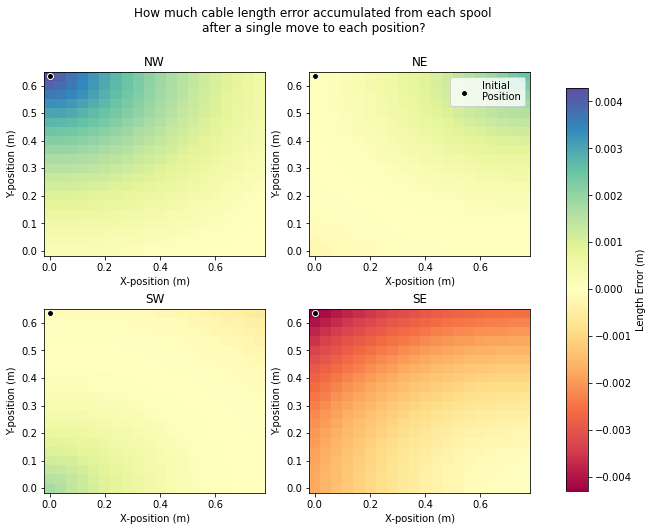

In [4]:
X,Y = np.meshgrid(xs, ys)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle('How much cable length error accumulated from each spool \nafter a single move to each position?')
kwargs = {
    'cmap': 'Spectral',
    'vmin': np.min([sw_errs.min(), nw_errs.min(), se_errs.min(), ne_errs.min()]),
    'vmax': np.max([sw_errs.max(), nw_errs.max(), se_errs.max(), ne_errs.max()])
}
im = axs[1][0].pcolormesh(X, Y, sw_errs, **kwargs)
axs[1][0].set_title('SW')

im = axs[0][0].pcolormesh(X, Y, nw_errs, **kwargs)
axs[0][0].set_title('NW')

im = axs[1][1].pcolormesh(X, Y, se_errs, **kwargs)
axs[1][1].set_title('SE')

im = axs[0][1].pcolormesh(X, Y, ne_errs, **kwargs)
axs[0][1].set_title('NE')

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i][j].scatter(init_pos[0], init_pos[1], edgecolor='w', facecolor='k', label='Initial\nPosition')
        axs[i][j].set_xlabel('X-position (m)')
        axs[i][j].set_ylabel('Y-position (m)')
        axs[i][j].set_aspect('equal')
# fig.tight_layout()
axs[0][1].legend(loc='best')
# https://stackoverflow.com/a/13784887
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.14, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Length Error (m)')

# plt.show()

In [5]:
# s = np.linspace(-1, 1, num=100)
# thets_pos = -r_sw + np.sqrt(2. * k * s + r_sw ** 2.) / k
# thets_neg = -r_sw - np.sqrt(2. * k * s + r_sw ** 2.) / k

# ax = plt.axes()
# ax.plot(thets_pos-thets_pos.mean(), s)
# ax.plot(thets_neg-thets_neg.mean(), s)

In [6]:
# ax = plt.axes()
# for r in np.linspace(.01, .1, num=200):
#     print(r)
#     ax.plot(s, np.sqrt(2. * k * s + r ** 2.))

Groups: <KeysViewHDF5 ['LabJack Cmd', 'algorithm']>
Datasets: <KeysViewHDF5 ['Addresses Turned On', 'Local Time (s)']>
Datasets: <KeysViewHDF5 ['Local Time (s)', 'Motor Delta Angle Command (rad)', 'Position Command (m)', 'Spool Radius Angle Correction (rad)']>


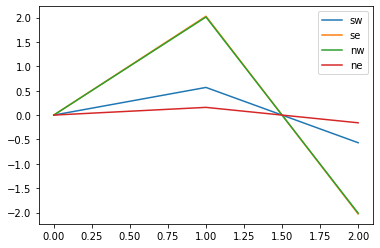

In [17]:
import h5py

f = h5py.File('F:\GitHub\hotspot\data\output\hotspot_20220120-223717.hdf5')
fig0 = plt.figure()
ax0 = plt.axes()

print('Groups:', f.keys())
for group in f.keys():
    print('Datasets:', f[group].keys())

rads = f['algorithm']['Spool Radius Angle Correction (rad)']
ax0.plot(rads[:] * 180. / np.pi)
ax0.legend(['sw', 'se', 'nw', 'ne'])

plt.show()